In [1]:
import pandas as pd
import requests
import json
import os.path
import numpy as np
import matplotlib.pyplot as plt
import pprint
import networkx as nx
import random as rnd

from matplotlib import colors as mcolors
from geopy.distance import geodesic
from pandas.io.json import json_normalize
kkk=0

In [2]:
colors = dict(mcolors.BASE_COLORS, **mcolors.CSS4_COLORS)

# Sort colors by hue, saturation, value and name.
by_hsv = sorted((tuple(mcolors.rgb_to_hsv(mcolors.to_rgba(color)[:3])), name)
                for name, color in colors.items())
sorted_names = [name for hsv, name in by_hsv]

kkk+=1;print("ordem",kkk)

('ordem', 1)


In [3]:
# Cesar para ver como faz a query consulte https://wiki.openstreetmap.org/wiki/Overpass_API/Overpass_QL
#
#
def getRodovias():
    poly = "-3.070145 -41.397623 -3.378076 -41.529317 -4.200684 -41.243993 -4.890447 -41.353599 -5.284097 -41.045815 -6.630547 -40.878812 -6.915577 -40.558076 -7.360932 -40.566191 -7.453001 -39.765866 -7.952970 -39.061235 -7.934419 -39.033309 -7.331740 -38.439331 -6.841795 -38.603392 -6.139325 -38.365410 -5.758917 -37.974206 -5.007089 -37.536193 -4.780404 -37.074409 -3.680291 -38.287696 -2.704505 -39.959576 -2.725466 -41.413189 -3.043958 -41.382122"
    overpass_url = "http://overpass-api.de/api/interpreter"
    overpass_query = '[out:json];'
    overpass_query = overpass_query + 'area[admin_level=2];'
    overpass_query = overpass_query + '('
    overpass_query = overpass_query + 'way["ref"~"^BR-"](poly:"'+str(poly)+'");'
    overpass_query = overpass_query + 'node(w);'
    overpass_query = overpass_query + 'way["ref"~"^CE-"](poly:"'+str(poly)+'");'
    overpass_query = overpass_query + 'node(w);'
    overpass_query = overpass_query + ');'
    overpass_query = overpass_query + 'out center;'
    response = requests.get(overpass_url, params={'data': overpass_query})
    data = response.json()
    return data
kkk+=1;print("ordem",kkk)

('ordem', 2)


In [4]:
#
# Get OSM Data
#
f = "data/data.json"
if(os.path.exists(f)):
    with open(f) as json_file:
        data = json.load(json_file)
else:
    data = getRodovias()
    with open(f, 'w') as fileo:
        json.dump(data, fileo)
        
kkk+=1;print("ordem",kkk)

('ordem', 3)


In [5]:
#
# Create Graph
#
def createG(data):
    G = nx.Graph()
    for element in data['elements']:
        if element['type'] == 'node':
            idn = element['id']
            lon = element['lon']
            lat = element['lat']
            G.add_node(idn,lat=lat,lon=lon,pos=(lon,lat),
                       cidade=0, nomeCidade="",visited=0)
    
    pos = nx.get_node_attributes(G,'pos')
    for element in data['elements']:
        ide = element['id']
        try:
            nodes = element['nodes']
        except:
            nodes = []
        lenNodes = len(nodes)
        if(lenNodes>0):
            try:
                ref = element['ref']
            except:
                ref=""
            try:
                name = element['name']
            except:
                name = ""
            for i in range(1,lenNodes):
                lon0,lat0 = pos[nodes[i]]
                lon1,lat1 = pos[nodes[i-1]]
                distance = geodesic((lat0,lon0),(lat1,lon1)).meters
                G.add_edge(nodes[i],nodes[i-1],
                           name=name,
                           ref=ref,
                           distance=distance)
    
    return G

G = createG(data)

kkk+=1;print("ordem",kkk)

('ordem', 4)


In [6]:
#
# First Plot
#
def plot1():
    pos = nx.get_node_attributes(G,'pos')
    draw = nx.draw_networkx_nodes(G,pos=pos,node_size=0.01)
    draw = nx.draw_networkx_edges(G,pos=pos,width=1)
    plt.savefig("export/ceara-ce-br.pdf")

kkk+=1;print("ordem",kkk)

('ordem', 5)


In [7]:
#
# Detect Cluster Agregates
#
cc = sorted(nx.connected_components(G), key = len, reverse=True)
pos = nx.get_node_attributes(G,'pos')
def plot2():
    lcc = list(cc[0])
    sorted_names = sorted_names + sorted_names
    pos = nx.get_node_attributes(G,'pos')
    for i in range(len(cc)):
        #if(i==len(sorted_names)): break
        if(len(cc[i])<=100):
            color = sorted_names[i]
            draw = nx.draw_networkx_nodes(G,pos=pos,node_size=0.05,nodelist=list(cc[i]),node_color=color)
    plt.savefig("export/ceara-ce-br-subG-le100.pdf")

kkk+=1;print("ordem",kkk)

('ordem', 6)


In [8]:
nx.write_gml(G,'export/G.gml')

kkk+=1;print("ordem",kkk)

('ordem', 7)


In [9]:
#
# Check Cities for Ceará State
#
def checkNodeNeig():
    dfcid = pd.read_csv("data/Municipios-Brasileiros/csv/municipios.csv",delimiter=",")
    dfcid["distancia"] = 1e10
    dfcid["node"] = 1

    # Ceará (23)
    dfcid = dfcid[dfcid.codigo_uf == 23]

    for i in dfcid.index:
        minV = dfcid.distancia.loc[i]
        lat0 = dfcid.latitude.loc[i]
        lon0 = dfcid.longitude.loc[i]
        cidade = dfcid.nome.loc[i]

        for n in list(G.nodes()):
            lon1,lat1 = pos[n]
            v = geodesic((lat0,lon0),(lat1,lon1)).meters
            if(v <= minV): 
                minV = v
                minN = n

        dfcid.distancia.at[i] = minV
        dfcid.node.at[i] = minN
        #print(cidade,minV,minN)

#
# Cria o arquivo de cidades mais proximo ao um vértice
#
try:
    dfcid = pd.read_pickle("data/cidades.plk")
except:
    print("Preciso criar o arquivo")
kkk+=1;print("ordem",kkk)

('ordem', 8)


In [10]:
#
# Update Cities into Graph
#

def plot3(dfcid,pos):
    draw = nx.draw_networkx_nodes(G,pos=pos,node_size=0.01)
    draw = nx.draw_networkx_nodes(G,pos=pos,nodelist=list(dfcid.node),node_size=5,node_color="blue")

    plt.savefig("export/ceara-ce-br-with-city.pdf")
#plot3(dfcid,pos)

cidades = nx.get_node_attributes(G,'cidade')
nome_cidades = nx.get_node_attributes(G,'nomeCidade')

for i in dfcid.index:
    cidade = dfcid.nome.loc[i]
    node = dfcid.node.loc[i]
    
    cidades[node] = 1
    nome_cidades[node] = cidade
    
nx.set_node_attributes(G,cidades,'cidade')
nx.set_node_attributes(G,nome_cidades,'nomeCidade') 

nodesCidades = list(dfcid.node)

nx.write_gml(G,'export/G.gml')


kkk+=1;print("ordem",kkk)

('ordem', 9)


In [11]:
#
# Check Nodes Endlist for each subgraph
#
degree = G.degree()
endlist = []
for n,d in degree:
    if(d<2): 
        endlist.append(n)

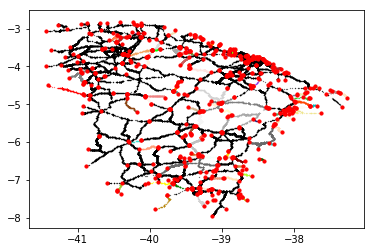

In [12]:
def plot4(sorted_names):
    lcc = list(cc[0])
    sorted_names = sorted_names + sorted_names
    pos = nx.get_node_attributes(G,'pos')
    for i in range(len(cc)):
        color = sorted_names[i]
        draw = nx.draw_networkx_nodes(G,pos=pos,node_size=0.05,nodelist=list(cc[i]),node_color=color)
    nx.draw_networkx_nodes(G,pos=pos,node_size=10,nodelist=endlist,node_color="red")
    plt.savefig("export/ceara-ce-br-subG.pdf")

plot4(sorted_names)

In [13]:
dist = nx.get_edge_attributes(G,'distance')

In [14]:
#
# Clear nodes not necessary 
#
def clearGraph(G,forbidem):

    G1 = G.copy()
    nodes = G.nodes()
    
    dist = nx.get_edge_attributes(G,'distance')
    name = nx.get_edge_attributes(G,'name')
    ref = nx.get_edge_attributes(G,'ref')
    
    removeNodes = []
    removeEdges = []
    
    k=0
    l=0
    for n in nodes:
        
        if(n not in forbidem):
            
            deg = G1.degree(n)
            if(deg == 0):
                G1.remove_node(n)
                k+=1
            elif(deg == 1):
                #
                # Not needs remove
                #
                neig = list(G1.neighbors(n))
                try:
                    dist1 = dist[n,back]
                except:
                    try:
                        dist1 = dist[back,n]
                    except:
                        dist1 = 0
                
            elif(deg == 2):
                neig = list(G1.neighbors(n))
                back = neig[0]
                forw = neig[1]

                try:
                    dist1 = dist[n,back]
                except:
                    try:
                        dist1 = dist[back,n]
                    except:
                        dist1 = 0
                        print(n,back)


                try:
                    dist2 = dist[n,forw]
                except:
                    try:
                        dist2 = dist[forw,n]
                    except:
                        dist2 = 0
                        print(n,forw)

                try:
                    name1 = name[n,back]
                except:
                    try:
                        name1 = name[back,n]
                    except:
                        name1 = 0
                        
                try:
                    ref1 = ref[n,back]
                except:
                    try:
                        ref1 = ref[back,n]
                    except:
                        ref1 = 0
                        
                if(back != forw and dist1 != 0 and dist2 != 0):
                    G1.add_edge(back,forw,
                               distance=dist1+dist2,
                               name=name1,
                               ref=ref1)

                    removeNodes.append(n)
                    removeEdges.append((n,back))
                    removeEdges.append((n,forw))

    for n1,n2 in removeEdges:
        try: G1.remove_edge((n1,n2))
        except: pass
        l+=1
     
    for n in removeNodes:
        try: G1.remove_node(n)
        except: pass
        k+=1
    
    print("# "+str(k)+" nodes and "+str(l)+" edges removed")
    return G1,k

G1,k = clearGraph(G,(nodesCidades+endlist))
while(k>1):
    G1,k = clearGraph(G1,(nodesCidades+endlist))

# 46129 nodes and 92258 edges removed
# 25401 nodes and 50802 edges removed
# 13827 nodes and 27654 edges removed
# 7697 nodes and 15394 edges removed
(1781280642, 621912756)
# 4130 nodes and 8260 edges removed
(1781280642, 5184116689)
# 2274 nodes and 4548 edges removed
# 1233 nodes and 2466 edges removed
(1643092535, 4518833493)
# 633 nodes and 1266 edges removed
# 312 nodes and 624 edges removed
# 127 nodes and 254 edges removed
# 30 nodes and 60 edges removed
# 2 nodes and 4 edges removed
# 1 nodes and 2 edges removed


In [15]:
def plot5(sorted_names,nodesCidades):
    cc1 = sorted(nx.connected_components(G1), key = len, reverse=True)
    print(len(cc1))
    pos1 = nx.get_node_attributes(G1,'pos')
    sorted_names = sorted_names + sorted_names
    for i in range(len(cc1)):
        color = sorted_names[i]
        draw = nx.draw_networkx_nodes(G1,pos=pos1,node_size=0.5,nodelist=list(cc1[i]),node_color=color)
    draw = nx.draw_networkx_nodes(G1,pos=pos1,nodelist=nodesCidades,node_size=5)
    draw = nx.draw_networkx_edges(G1,pos=pos1,width=1)
    plt.savefig("export/ceara-ce-br-filtered.pdf")
#plot5(sorted_names,nodesCidades)
kkk+=1;print("ordem",kkk)

('ordem', 10)


In [16]:
#
# Verifica sítios vizinhos as Cidades
#
def checkNeig(cc):
    
    lenCC = len(cc)
    minsV = np.zeros((lenCC,lenCC))
    nodesMin = {}
    minsV = minsV + 1e10
    k=0
    for i in range(lenCC):
        nodesI = cc[i]
        #print("#",i,len(nodesI))
        for ni in nodesI:
            lon0, lat0 = pos[ni]
            for j in range(i+1,lenCC):
                nodesJ = cc[j]
                #print("##",j,len(nodesJ))
                for nj in nodesJ:
                    lon1, lat1 = pos[nj]
                    minv = minsV[i,j]
                    v = geodesic((lat0,lon0),(lat1,lon1)).meters
                    #print(k,i,ni,j,nj,minv,v)
                    if(v<minv): 
                        minsV[i,j] = v
                        nodesMin[i,j] = (ni,nj)
                    #if(k>100): return
                    k+=1
    return minsV, nodesMin

#
# Cria a matriz de vizinhanca
#
print(G1.number_of_nodes())
cc1 = sorted(nx.connected_components(G1), key = len, reverse=True)
try:
    minsV = np.load("data/minsV.npy")
    

    nodesMin = np.load("data/nodesMin.npy")
except:
    print("Precisa criar o arquivo")
    minsV, nodesMin = checkNeig(cc1)
    #print(minsV, nodesMin)
    np.save("data/minsV",minsV)
    np.save("data/nodesMin",nodesMin)
    
kkk+=1;print("ordem",kkk)

1762
('ordem', 11)


In [17]:
#
# Calc Minimal Distance between nodes
#
G2 = G1.copy()

nodesMinA = (nodesMin.item())
k=0
joinList = []
for i in range(166):
    for j in range(166):
        v = minsV[i,j]
        if(v<5000):
            k+=1
            joinList.append(nodesMinA[i,j][0])
            joinList.append(nodesMinA[i,j][1])
            G2.add_edge(nodesMinA[i,j][0],nodesMinA[i,j][1],
                        distance=v,ref="join",name="join",ide="join")
            #print(i,j,v)
cc1 = sorted(nx.connected_components(G2), key = len, reverse=True)
print("subG",len(cc1))
print(k,166*166)

('subG', 18)
(277, 27556)
